<a href="https://colab.research.google.com/github/duncansnh/burn-mapping/blob/region_growing/CUU_burn_extent_image_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Script to threshold an input image based on one or more index thresholds
Inputs are

1)  indices generated from sentinel 2 imagery (generated from previous script) 

Main steps:
•	threshold the image

Duncan Blake NatureScot 30 September 2020

Changes 13 November 2020: 

Extra code to create a second thresholding layer to test whether this is a viable alternative to region growing

In [51]:
#This is only required if running in colab notebook to install the libraries
#If running Python code elsewhere need to make sure below libraries are installed
! pip install geopandas
! pip install descartes
! pip install rasterio
! pip install rasterstats
! pip install pygeos #required for spatial indexing in geopandas

     |████████████████████████████████| 1.6MB 6.2MB/s 


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import geopandas as gpd
import descartes
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.features import sieve, shapes
from shapely.geometry import mapping, shape
from rasterstats import zonal_stats
import gdal
import pprint
import pygeos

In [8]:
#Only if running in Google Colab, in which case input image, training polygons and output results need to be in Google Drive.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Set working drive, file paths and dataset name parameters


In [9]:

wd = '/content/drive/My Drive'
image_dir = os.path.join(wd, 'Imagery')
plot_dir = os.path.join(wd, 'Plots')

# Cairngorms parameters
image = 'CUU_burn_cairngorms_indices.tif'
outImage = 'CUU_burn_cairngorms_core_burns.tif'
outCorePoly = 'CUU_burn_cairngorms_core_burns.shp'

# Skye parameters
# image = 'CUU_burn_skye_indices.tif'
# outImage = 'CUU_burn_skye_core_burns.tif'

###Open input image and polygon dataset

(884, 1343)
PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000043,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


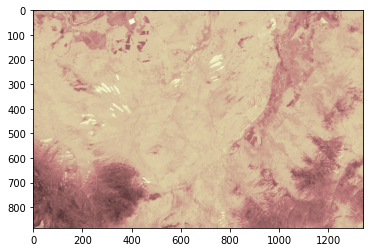

In [31]:
# Read image
s2 = rasterio.open(os.path.join(image_dir,image))
print(s2.shape)
profile = s2.profile.copy()
# optionally check all ok by showing dsavi layer
plt.imshow(s2.read(21), cmap='pink')
print(s2.crs)
# plt.show()
# print(type(s2))

## Import pickled dataframe and determine threshold values from percentiles


In [11]:
# read in pickled object of all data combined (created from previous script that generated the boxplots)
pickleName = ("All_data_for_thresholding.pkl")
df_all_data = pd.read_pickle(os.path.join(plot_dir,pickleName))

# obtain percentile values
# isolate burn rows in dataframe
df_burns = df_all_data[df_all_data.Class == "Burns"]
# subset columns we are interested in
df_burns_indices = df_burns[['dnbr','dnbr2','dcsi','dsavi','postnbr']]
# extract quartile statistics needed

# medians
print("medians")
dNBRQ2 = df_burns_indices.dnbr.quantile(0.5)
print(dNBRQ2)
dSAVIQ2 = df_burns_indices.dsavi.quantile(0.5)
print(dSAVIQ2)
postNBRQ2 = df_burns_indices.postnbr.quantile(0.5)
print(postNBRQ2)

# 75th percentile
print("75th percentiles")
dNBRQ3 = df_burns_indices.dnbr.quantile(0.75)
print(dNBRQ3)
dSAVIQ3 = df_burns_indices.dsavi.quantile(0.75)
print(dSAVIQ3)
postNBRQ3 = df_burns_indices.postnbr.quantile(0.75)
print(postNBRQ3)
dNBR2Q3 = df_burns_indices.dnbr2.quantile(0.75)
print(dNBR2Q3)

# 25th percentile for extended areas
print("25th percentiles")
dSAVIQ1 = df_burns_indices.dsavi.quantile(0.25)
print(dSAVIQ1)
postNBRQ1 = df_burns_indices.postnbr.quantile(0.25)
print(postNBRQ1)

medians
0.214064359664917
0.2852725386619568
0.23950617015361786
75th percentiles
0.2735748812556267
0.3618958219885826
0.2981530427932739
0.1445029228925705
25th percentiles
0.20674878358840942
0.17344753444194794


## Set the threshold


In [12]:
# for multiple indices threshold
# read in bands required 2 postnbr; 3 dnbr; 6 dnbr2; 15 dcsi; 21 dsavi 
indicesArray = s2.read([2,3,6,15,21])

# read in a single band as a template for the output reclassified image containing core burn pixels
band1 = s2.read(1)
reclassArray = band1.copy()
# reset all values in output raster to 0 as otherwise pixel values not reclassed by the condition below may retain value from prenbr (band1)
reclassArray[np.where(reclassArray != 0)] = 0

# set up second array to hold extended burn area
extendArray = np.copy(reclassArray)

# reclassify the array to contain core burn pixels
# in this case where dsavi is greater than the median and post fire image NBR is greater than the median 
reclassArray[np.where((indicesArray[4]>=dSAVIQ2) & (indicesArray[0]>=postNBRQ2))] = 1 
# then attempt to solve issue of edges of clouds being falsely identified which have high values in dnbr2
reclassArray[np.where(indicesArray[2]>=0.8)] = 0

# rasterio function to exclude clumps of pixels smaller than 3.  Diagonally joined pixels are allowed.
sievedArray = sieve(reclassArray.astype(rasterio.uint8), size=3, connectivity=8)

# reclassify the second array to contain extended burn pixels
# in this case where dsavi is greater than the median and post fire image NBR is greater than the median 
extendArray[np.where(indicesArray[4]>=dSAVIQ1)] = 1 

# rasterio function to exclude clumps of pixels smaller than 3.  Diagonally joined pixels are allowed.
sievedExtendArray = sieve(extendArray.astype(rasterio.uint8), size=3, connectivity=8)

## Plot the thresholded rasters

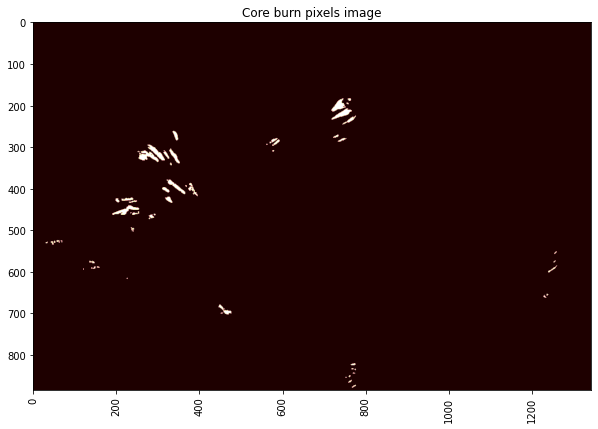

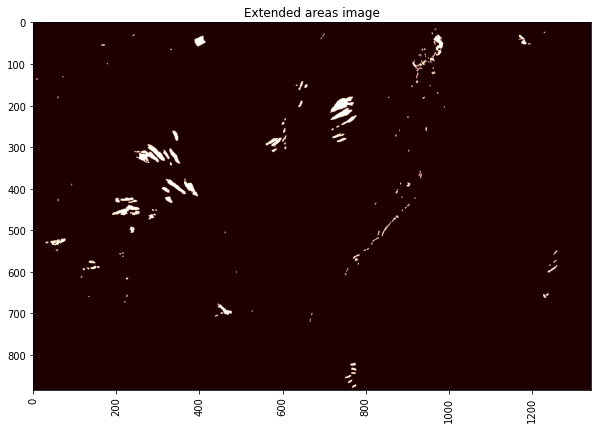

In [13]:
# an inital look to see if in the right ballpark but viewing in GIS is much better!
plt.figure(figsize=(10,8)); 
plt.imshow(sievedArray,cmap='pink')
plt.title('Core burn pixels image')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

plt.figure(figsize=(10,8)); 
plt.imshow(sievedExtendArray,cmap='pink')
plt.title('Extended areas image')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees


## Extract burn extents where they overlap with core poixels

In [72]:
# code adapted from https://github.com/mapbox/rasterio/blob/fb93a6425c17f25141ad308cee7263d0c491a0a9/examples/rasterio_polygonize.py

# create shapes from numpy array (the transform argument from the original image is essential otherwise 
# image coordinates rather than BNG coordinates are used for the features )
# NB 'shapes' from rasterio' creates geoJSON generator objects
# TODO would be better written as a function
coreShapes = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(sievedArray, transform=s2.transform)))

coreShapesGeoms = list(coreShapes)
# convert geoJSON objects to a geopandas data frame
gpd_coreShapes  = gpd.GeoDataFrame.from_features(coreShapesGeoms)

# it has no projection though so this is defined
gpd_coreShapes = gpd_coreShapes.set_crs(epsg=27700)

# check it looks ok and crs has been set
gpd_coreShapes.plot()
print(gpd_coreShapes.crs)

#### now tdo the same for extended burn areas ####
extendShapes = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(sievedExtendArray, transform=s2.transform)))

extendShapesGeoms = list(extendShapes)
# convert geoJSON objects to a geopandas data frame
gpd_extendShapes  = gpd.GeoDataFrame.from_features(extendShapesGeoms)

# it has no projection though so this is defined
gpd_extendShapes = gpd_extendShapes.set_crs(epsg=27700)

# check it looks ok and crs has been set
gpd_extendShapes.plot()
print(gpd_extendShapes.crs)
print(gpd_extendShapes.info)

# subset to only include those polys with a value of 1
gpd_extendBurnShapes = gpd_extendShapes[gpd_extendShapes["raster_val"] == 1.0]
print(gpd_extendBurnShapes.info)

gpd_coreBurnShapes = gpd_coreShapes[gpd_coreShapes["raster_val"] == 1.0]
print(gpd_coreBurnShapes.info)

# now we need to overlap the two and create a dataset of all extended burn areas
# that extend at least partially over core burn areas

gpd_finalShapes = gpd.sjoin(gpd_extendBurnShapes, gpd_coreBurnShapes, how="inner", op='within')

gpd_finalShapes = gpd_coreShapes[gpd_coreShapes.within(gpd_extendShapes)]
print(gpd_finalShapes.info)
# export to shapefile
#gpd_coreShapes.to_file(os.path.join(image_dir, outCorePoly), driver='ESRI Shapefile')





<bound method DataFrame.info of                                               geometry  raster_val
0    POLYGON ((334589.816 794646.312, 334589.816 79...         1.0
1    POLYGON ((334569.817 794626.321, 334569.817 79...         1.0
2    POLYGON ((337199.767 794566.346, 337199.767 79...         1.0
3    POLYGON ((334499.818 794546.355, 334499.818 79...         1.0
4    POLYGON ((331899.867 794526.363, 331899.867 79...         1.0
..                                                 ...         ...
240  POLYGON ((332569.855 786499.775, 332569.855 78...         1.0
241  POLYGON ((332599.854 786399.817, 332599.854 78...         1.0
242  POLYGON ((332519.855 786329.847, 332519.855 78...         1.0
243  POLYGON ((332549.855 786209.898, 332549.855 78...         1.0
244  POLYGON ((332649.853 786099.945, 332649.853 78...         1.0

[232 rows x 2 columns]>
<bound method DataFrame.info of                                              geometry  raster_val
0   POLYGON ((332519.855 792977.022, 3325

## Export the thresholded raster

In [ ]:
# export the classified array, converting to an integer
profile.update(dtype=rasterio.uint8,
        count=1,
        compress='lzw')  

with rasterio.open(os.path.join(image_dir,outImage), 'w', **profile) as dst:
        dst.write(sievedArray, 1)